In [1]:
import numpy as np

In [2]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

def dfunc(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:     
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()   
    return grad

def cross_entropy_err(y_hat, y):
    delta = 1e-8
    return -np.sum(y*np.log(y_hat + delta))

In [3]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
 
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid_function(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax_function(a2)
        return y
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return cross_entropy_err(y_hat, y)
        
    def numerical_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)
        grads = {}
        grads['W1'] = dfunc(loss_W, self.params['W1'])
        grads['b1'] = dfunc(loss_W, self.params['b1'])
        grads['W2'] = dfunc(loss_W, self.params['W2'])
        grads['b2'] = dfunc(loss_W, self.params['b2'])
        return grads

In [4]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

In [5]:
net.params['W1']

array([[-0.00999212,  0.00023952,  0.01225109, -0.00578119, -0.00530105],
       [ 0.01837809, -0.0034991 ,  0.00137951, -0.01298947,  0.00884884],
       [-0.01104285,  0.01123044,  0.00848096,  0.00127694,  0.00101045],
       [ 0.00277641,  0.0043066 ,  0.00626061, -0.01373687, -0.00482733]])

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
x= iris.data

In [7]:
input_x = np.array([[5.1, 3.5, 1.4, 0.2]])
net.predict(input_x)

array([[0.33370794, 0.33434379, 0.33194826]])

In [8]:
y = np.zeros((len(iris.target), 3))
for idx, val in enumerate(iris.target):
  y[idx, val] = 1

In [9]:
output_y = np.array([1., 0., 0.])

In [10]:
net.loss(input_x,output_y)

1.0974890652248435

In [11]:
import time
epochs = 3000
lr   = 0.01
a = time.clock()
train_loss = []
for i in range(epochs): 
  grad = net.numerical_gradient(x,y)
  for key in ('W1', 'b1', 'W2', 'b2'):
    net.params[key] = net.params[key] - lr * grad[key]
  loss = net.loss(x, y)
  train_loss.append(loss)
print(time.clock() -a )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


21.684755000000003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


## Back Propagation

In [12]:
class Relu:
  def __init__(self):
    self.cache = None
    
  def forward(self, x):
    self.cache = (x <=0)
    out = np.maximum(0,x)
    return out

  def backward(self, dout):
    dout[self.cache] = 0
    dx = dout
    return dx

In [13]:
f = Relu()

In [14]:
x = np.array([-1,1,2])
f.forward(x)

array([0, 1, 2])

In [15]:
f.cache

array([ True, False, False])

In [16]:
out = np.array([2,2,2])

In [17]:
f.backward(out)

array([0, 2, 2])

- https://www.wolframalpha.com/input/?i=derivative+1%2Fx

In [18]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1/ (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        y  = self.out
        dx = dout * y * (1-y)
        return dx

In [19]:
s = Sigmoid()

In [20]:
ary = np.array([-1,1,2])
s.forward(ary)

array([0.26894142, 0.73105858, 0.88079708])

In [21]:
out = np.array([2,2,2])
s.backward(out)

array([0.39322387, 0.39322387, 0.20998717])

In [22]:
2 * 0.26894142 * (1- 0.26894142)

0.39322386521676717

In [23]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout)
        return dx

In [24]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y_hat = None 
        self.y = None 

    def forward(self, x, y):
        self.y = y
        self.y_hat = softmax_function(x)
        self.loss = cross_entropy_err(self.y_hat, self.y)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y_hat - self.y) / batch_size
        return dx

In [25]:
import numpy as np
from collections import OrderedDict

class ANN:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return self.lastLayer.forward(y_hat, y)
  
    def gradient(self, x, y):
        # forward
        self.loss(x, y)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [26]:
import random
import time

epochs     = 3000
lr         = 0.01
batch_size = 30

net = ANN(input_size=4, hidden_size=5, output_size=3)

t0 = time.clock()
train_loss = []
for i in range(epochs): 
    idx = np.random.choice(iris.data.shape[0], batch_size)
    x_batch   = iris.data[idx]
    y_batch   = y[idx]
    grad = net.gradient(x_batch,y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= lr * grad[key]
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)
    
time.clock() - t0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.5818330000000032

### Scikit Learn

In [27]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [31]:
import numpy as np
s = np.array([0,10,20,30,50,100,200])
s

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

s2 = sigmoid_function(s)
s2

array([0.5      , 0.9999546, 1.       , 1.       , 1.       , 1.       ,
       1.       ])

In [34]:
# (x - mu) / std
s_ = (s - s.mean()) / s.std()
s2_ = sigmoid_function(s_)
s2_

array([0.28979036, 0.32227026, 0.35656286, 0.39239179, 0.46725174,
       0.65340512, 0.8970145 ])

In [41]:
s_

array([-0.89640241, -0.7433581 , -0.59031378, -0.43726947, -0.13118084,
        0.63404073,  2.16448387])

In [39]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
s.reshape(-1, 1)


array([[  0],
       [ 10],
       [ 20],
       [ 30],
       [ 50],
       [100],
       [200]])

In [40]:
sc.fit_transform(s.reshape(-1, 1))

array([[-0.89640241],
       [-0.7433581 ],
       [-0.59031378],
       [-0.43726947],
       [-0.13118084],
       [ 0.63404073],
       [ 2.16448387]])

In [42]:
# fit : generate mean, std
# transform: transform data
# fit_transform: generate mean, std, then transform data

In [44]:
sc.mean_, sc.var_

(array([58.57142857]), array([4269.3877551]))

In [45]:
sc = StandardScaler()
X = sc.fit_transform(iris.data)
y = iris.target

In [47]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [55]:
f# 4 -> 5 -> 3
from sklearn.neural_network import MLPClassifier
#?MLPClassifier
clf = MLPClassifier( hidden_layer_sizes =(5,) , activation = 'logistic', solver  = 'sgd', max_iter = 3000)
clf.fit(X,y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=3000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [56]:
pred_y = clf.predict(X)

In [59]:
(y == pred_y).sum() / len(pred_y)

0.8866666666666667

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y, pred_y)

0.8866666666666667

In [61]:
confusion_matrix(y, pred_y)

array([[50,  0,  0],
       [ 0, 34, 16],
       [ 0,  1, 49]])

In [65]:
from sklearn.neural_network import MLPClassifier
#?MLPClassifier
clf = MLPClassifier( hidden_layer_sizes =(5,) , solver  = 'sgd', max_iter = 10000)
clf.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred_y = clf.predict(X)
accuracy_score(y, pred_y)

0.9533333333333334

## MNIST Problem

In [67]:
from sklearn.datasets import load_digits
digits = load_digits()

In [68]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [69]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [70]:
digits.data.shape

(1797, 64)

In [72]:
digits.images.shape

(1797, 8, 8)

In [73]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

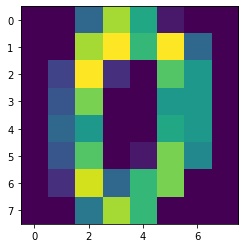

In [74]:
from matplotlib import pyplot as plt
plt.imshow(digits.images[0])

In [75]:
digits.target[0]

0

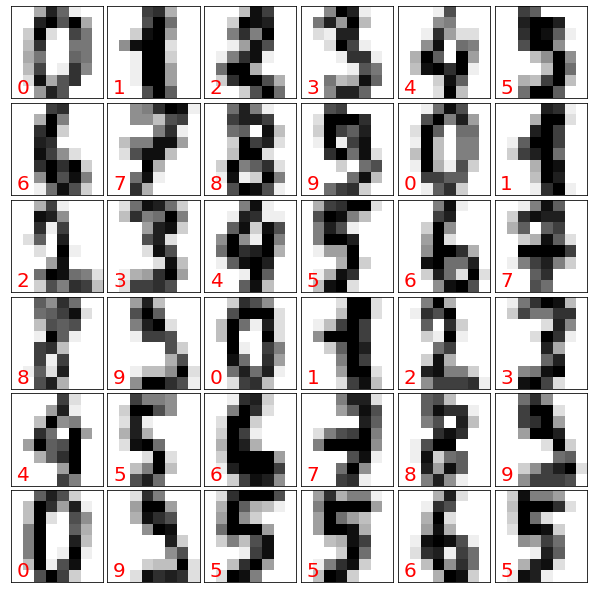

In [76]:
fig = plt.figure(figsize = (8,8))

# 圖與圖的間距
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 取樣36 張圖
for i in range(36):
    # 每張 6 * 6 的大小
    ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
    # 繪製灰階圖
    ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
    # 於左下標示紅色大小為20數字
    ax.text(0, 7, digits.target[i], color="r", fontsize = 20)

In [78]:
digits.data.shape

(1797, 64)

In [79]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(digits.data)

In [80]:
X_scaled

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

In [81]:
# 64 -> 30 -> 10
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( hidden_layer_sizes =(30,30,30,) , solver  = 'sgd', max_iter = 1000)
clf.fit(X_scaled,digits.target)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [83]:
predicted = clf.predict(X_scaled)

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(digits.target, predicted)

0.9977740678909294

In [85]:
confusion_matrix(digits.target, predicted)

array([[178,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 182,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 177,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 182,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 181,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 179,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0, 173,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 179]])

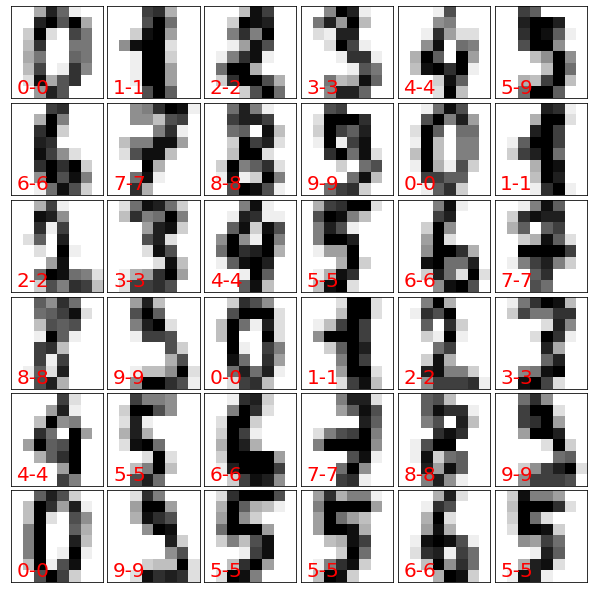

In [86]:
fig = plt.figure(figsize = (8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(36):
  ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
  ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
  ax.text(0, 7, '{}-{}'.format(digits.target[i],predicted[i]), color="red", fontsize = 20)


In [88]:
clf.coefs_[0]

array([[-0.05432784,  0.0030218 ,  0.04502747, ..., -0.15130056,
         0.14419791,  0.19474398],
       [ 0.02953598,  0.0697499 , -0.1958164 , ..., -0.12245734,
        -0.0390427 , -0.12123463],
       [-0.2564587 , -0.08997708, -0.2450324 , ...,  0.21821492,
         0.00317387, -0.0852212 ],
       ...,
       [ 0.20451573,  0.21510141, -0.13630205, ..., -0.06248469,
        -0.23862207, -0.50718221],
       [ 0.01988876,  0.18999365, -0.25286742, ..., -0.29982016,
        -0.22370142, -0.17642451],
       [-0.13111792, -0.03962111,  0.06630459, ..., -0.04402813,
         0.05438185,  0.0707858 ]])

In [89]:
clf.coefs_[0].shape

(64, 30)

In [90]:
! wget https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/unknown_digits.bmp

--2021-03-27 03:29:28--  https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/unknown_digits.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150 [image/bmp]
Saving to: ‘unknown_digits.bmp’

unknown_digits.bmp  100%[===================>]     150  --.-KB/s    in 0s      

2021-03-27 03:29:29 (4.04 MB/s) - ‘unknown_digits.bmp’ saved [150/150]



In [93]:
from PIL import Image
Image.open('unknown_digits.bmp')

In [94]:
im = np.array(Image.open('unknown_digits.bmp'))

In [95]:
im

array([[15, 15, 15, 15, 15, 15, 15, 15],
       [15, 15,  0, 15,  0, 15, 15, 15],
       [15, 15,  0, 15,  0, 15, 15, 15],
       [15,  0,  0, 15,  0, 15, 15, 15],
       [15,  0, 15, 15,  0, 15, 15, 15],
       [ 0,  0,  0,  0,  0,  0,  0, 15],
       [15, 15, 15, 15,  0, 15, 15, 15],
       [15, 15, 15, 15,  0, 15, 15, 15]], dtype=uint8)

In [96]:
15 - im

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 15,  0, 15,  0,  0,  0],
       [ 0,  0, 15,  0, 15,  0,  0,  0],
       [ 0, 15, 15,  0, 15,  0,  0,  0],
       [ 0, 15,  0,  0, 15,  0,  0,  0],
       [15, 15, 15, 15, 15, 15, 15,  0],
       [ 0,  0,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  0,  0,  0]], dtype=uint8)

In [97]:
im2 = (15 - im).reshape(64,)

In [98]:
im2

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0, 15,  0,  0,  0,  0,
        0, 15,  0, 15,  0,  0,  0,  0, 15, 15,  0, 15,  0,  0,  0,  0, 15,
        0,  0, 15,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0,
        0, 15,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0], dtype=uint8)

In [99]:
src = sc.transform([im2])

In [100]:
src

array([[ 0.00000000e+00, -3.35016487e-01, -1.09493684e+00,
        -2.78643746e+00, -2.76424203e+00, -1.02065685e+00,
        -4.09723921e-01, -1.25022923e-01, -5.90775571e-02,
        -6.24009262e-01,  8.51981802e-01, -3.01259995e+00,
         9.87303977e-01, -1.35109507e+00, -5.14991458e-01,
        -1.30433381e-01, -4.46250733e-02, -7.27646281e-01,
         8.95880438e-01, -1.20543167e+00,  1.27989088e+00,
        -1.25998248e+00, -5.48805463e-01, -1.14221844e-01,
        -3.33797263e-02,  3.98337420e+00,  9.54513151e-01,
        -1.49990136e+00,  8.24810596e-01, -1.28625035e+00,
        -6.28895882e-01, -4.72323823e-02,  0.00000000e+00,
         3.63871114e+00, -1.21260656e+00, -1.44763006e+00,
         7.92062324e-01, -1.48986148e+00, -8.22694515e-01,
         0.00000000e+00,  1.03283569e+02,  4.50060728e+00,
         1.24209958e+00,  1.20688552e+00,  1.17098727e+00,
         1.18784054e+00,  2.66613420e+00, -8.87416172e-02,
        -3.54332626e-02, -4.03574986e-01, -1.33033057e+0

In [101]:
clf.predict(src)

array([4])